In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score



In [3]:
# Define the ResNet-18 model
class ResNet18Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18Classifier, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        in_features = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet18(x)



In [4]:
# Define transformation for training and validation data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define the dataset using ImageFolder
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Dataset2/Augmented_images/train', transform=transform)
#test_dataset = datasets.ImageFolder(r'D:\Unclassified_data\data\croped_images\test', transform=transform)
val_dataset = datasets.ImageFolder('/content/drive/MyDrive/Dataset2/Augmented_images/val', transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Check if a CUDA GPU is available and if not, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Initialize the model, optimizer, and loss function
num_classes = len(train_dataset.classes)
model = ResNet18Classifier(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]


In [7]:
# Training loop
num_epochs = 500
best_val_loss = float('inf')
best_epoch = -1

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_total_loss = 0.0
    val_predictions = []
    val_true_labels = []

    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_total_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_predictions.extend(predicted.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    val_loss = val_total_loss / len(val_loader)

    print(f"Epoch {epoch + 1}/{num_epochs}, "
          f"Train Loss: {average_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.4f}")

    # Save the model with the best validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        torch.save(model.state_dict(), '/content/drive/MyDrive/Dataset2/best_mode2.pth')

print(f"Best validation loss achieved at epoch {best_epoch}: {best_val_loss:.4f}")


Epoch 1/500, Train Loss: 0.7171, Val Loss: 0.7808, Val Accuracy: 0.6000
Epoch 2/500, Train Loss: 0.3261, Val Loss: 0.6517, Val Accuracy: 0.6778
Epoch 3/500, Train Loss: 0.1842, Val Loss: 0.6810, Val Accuracy: 0.6889
Epoch 4/500, Train Loss: 0.0962, Val Loss: 0.9688, Val Accuracy: 0.6056
Epoch 5/500, Train Loss: 0.0733, Val Loss: 0.8887, Val Accuracy: 0.6611
Epoch 6/500, Train Loss: 0.0756, Val Loss: 0.6208, Val Accuracy: 0.7056
Epoch 7/500, Train Loss: 0.0568, Val Loss: 0.6626, Val Accuracy: 0.6944
Epoch 8/500, Train Loss: 0.0338, Val Loss: 0.8990, Val Accuracy: 0.6833
Epoch 9/500, Train Loss: 0.0391, Val Loss: 1.0172, Val Accuracy: 0.6667
Epoch 10/500, Train Loss: 0.0304, Val Loss: 1.2707, Val Accuracy: 0.6167
Epoch 11/500, Train Loss: 0.0259, Val Loss: 1.1166, Val Accuracy: 0.6556
Epoch 12/500, Train Loss: 0.0293, Val Loss: 0.8157, Val Accuracy: 0.6889
Epoch 13/500, Train Loss: 0.0284, Val Loss: 1.2560, Val Accuracy: 0.6389
Epoch 14/500, Train Loss: 0.0114, Val Loss: 0.6109, Val Accu

In [9]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Define transformation for test data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Define the test dataset using ImageFolder
test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Dataset2/croped_images/test', transform=transform)

# Define a data loader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the pretrained ResNet-18 model (or the model you trained)
model = ResNet18Classifier(num_classes).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Dataset2/best_mode2.pth'))  # Load the best model

# Put the model in evaluation mode
model.eval()

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Test the model on the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Compute the test accuracy
test_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.8889


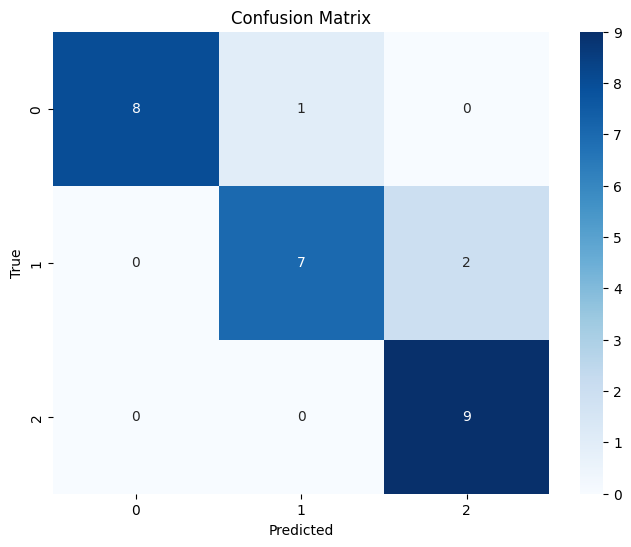

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Define class labels (if available) for labeling the confusion matrix
class_labels = [str(label) for label in range(num_classes)]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
